### Oppgave 5 Visualisering
#### Importerer nødvendige biblioteker

In [60]:
import sys
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import missingno as msno
import ipywidgets as widgets

#### Valg av flyplass, enten ENOL eller ENBO

In [61]:
#airport = "ENBO"
airport = "ENOL"

In [62]:
file_path = f'../data/csv/{airport}_wind_data.csv'
df_airport = pd.read_csv(file_path)

#### Visualisering av parameter for de ulike variablene

<Axes: >

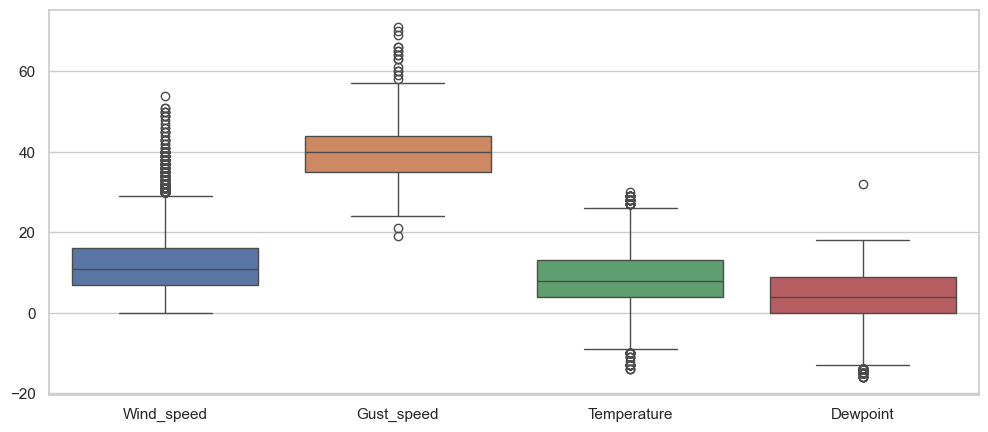

In [63]:
sns.set(rc={'figure.figsize':(12,5)}, style='whitegrid')
sns.boxplot(data=df_airport[['Wind_speed', 'Gust_speed', 'Temperature', 'Dewpoint']])

Q-Q Plots for å identifisere skjevhet

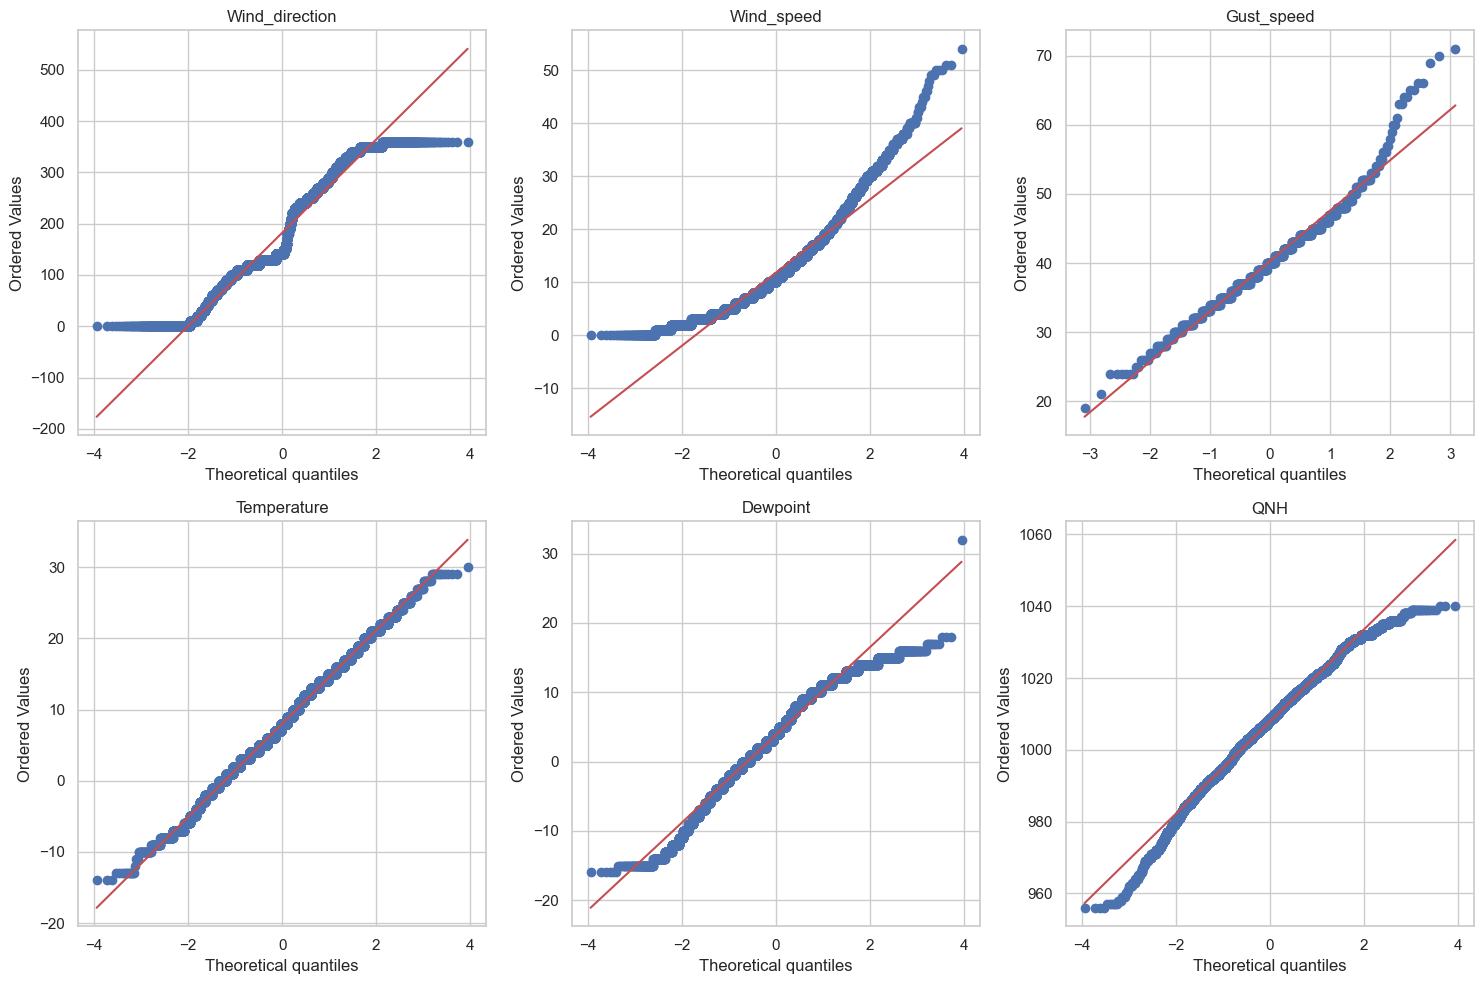

In [64]:
# Velger kun numeriske verdier i dataframen
df_numeric = df_airport.select_dtypes(include=[np.number])

n_cols = 3
n_rows = int(np.ceil(len(df_numeric.columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5))
axes = axes.flatten()

for i, column in enumerate(df_numeric.columns):
    stats.probplot(df_numeric[column].dropna(), dist="norm", plot=axes[i])
    axes[i].set_title(column)

# Skjul eventuelle tomme subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Positiv skjevhet (høyreskjev)
- Flest observasjoner er lave, men det finnes noen høye ytterverdier.

#### Negativ skjevhet (venstreskjev)
- Flest observasjoner er høye, men det finnes noen lave ytterverdier.

#### Skjevhet i vårt datasett
- Vi ser at Temperatur er den eneste med liten skjevhet i begge retninger.

- Wind_direction er skjev i begge retninger.

- Dewpoint og QNH er høyreskjeve, altså positiv skjevhet, og Wind_speed, Gust_speed er primært venstreskjeve, altså negativ skjevhet.

Skjevheten sier noe om kvaliteten i statistisk data, som gjennomsnitt. For eksempel er Wind_speed ofte lav, med noen få ekstremt høye tilfeller (orkan). Dette medfører at gjennomsnttet blir dratt opp.

Dette er betraktninger vi tar med oss videre i prediktiv analyse

#### Histogram av data
Viser oss fordelingen av all værdata

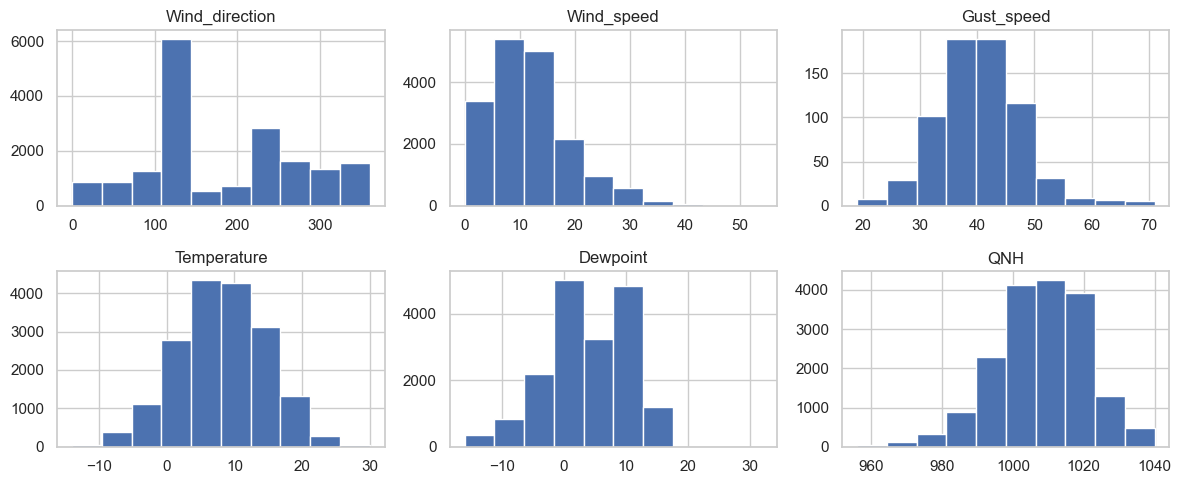

In [65]:
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()

for i, col in enumerate(df_numeric.columns):
    df_numeric[col].hist(ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()


### Tilbake til data cleaning og missing data
Ser fra oppgave 4 og 5, at vi forventet manglende data i vindkast. Ved å benytte "missingno" bibliotek klarer vi å visualiserer manglende data i vår data frame. 

Matrise for visualisering av missing data


<Axes: >

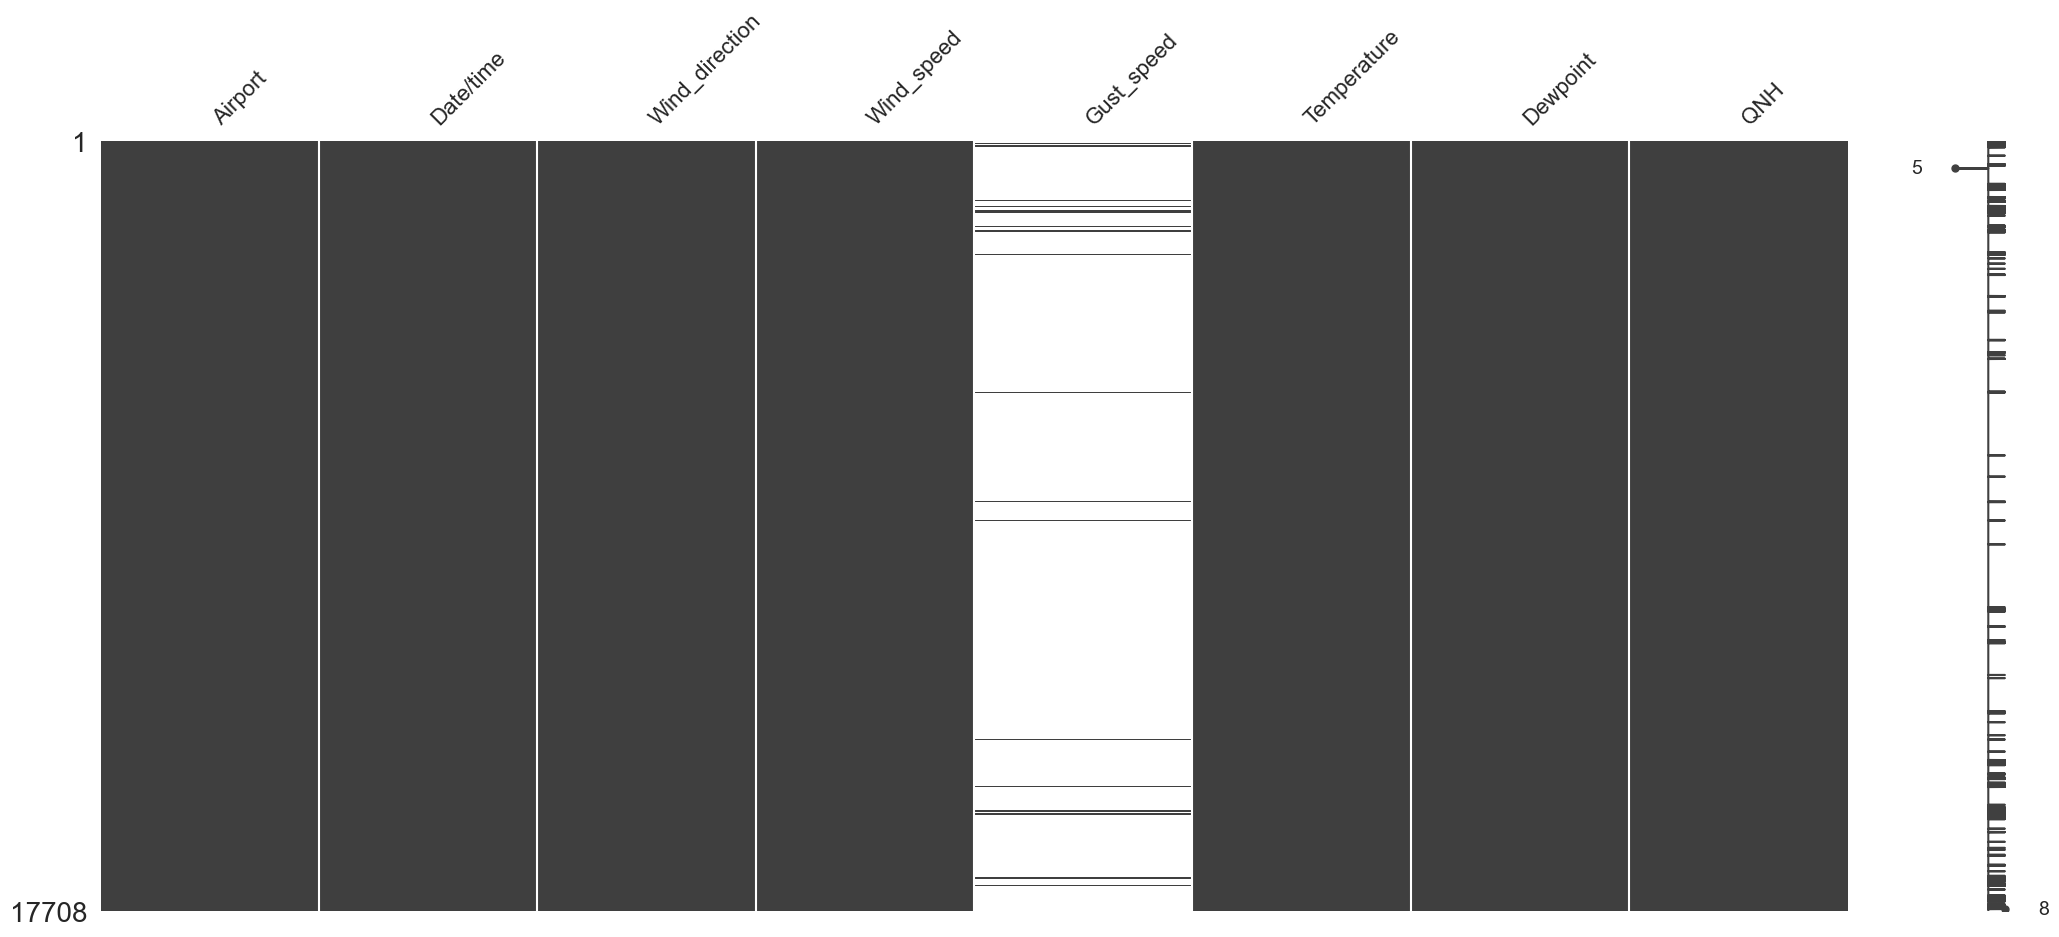

In [66]:
print("Matrise for visualisering av missing data")
msno.matrix(df_airport)

Denne viser tydelig mangler under kolonnen "Gust_speed". 

Ser etter outliers


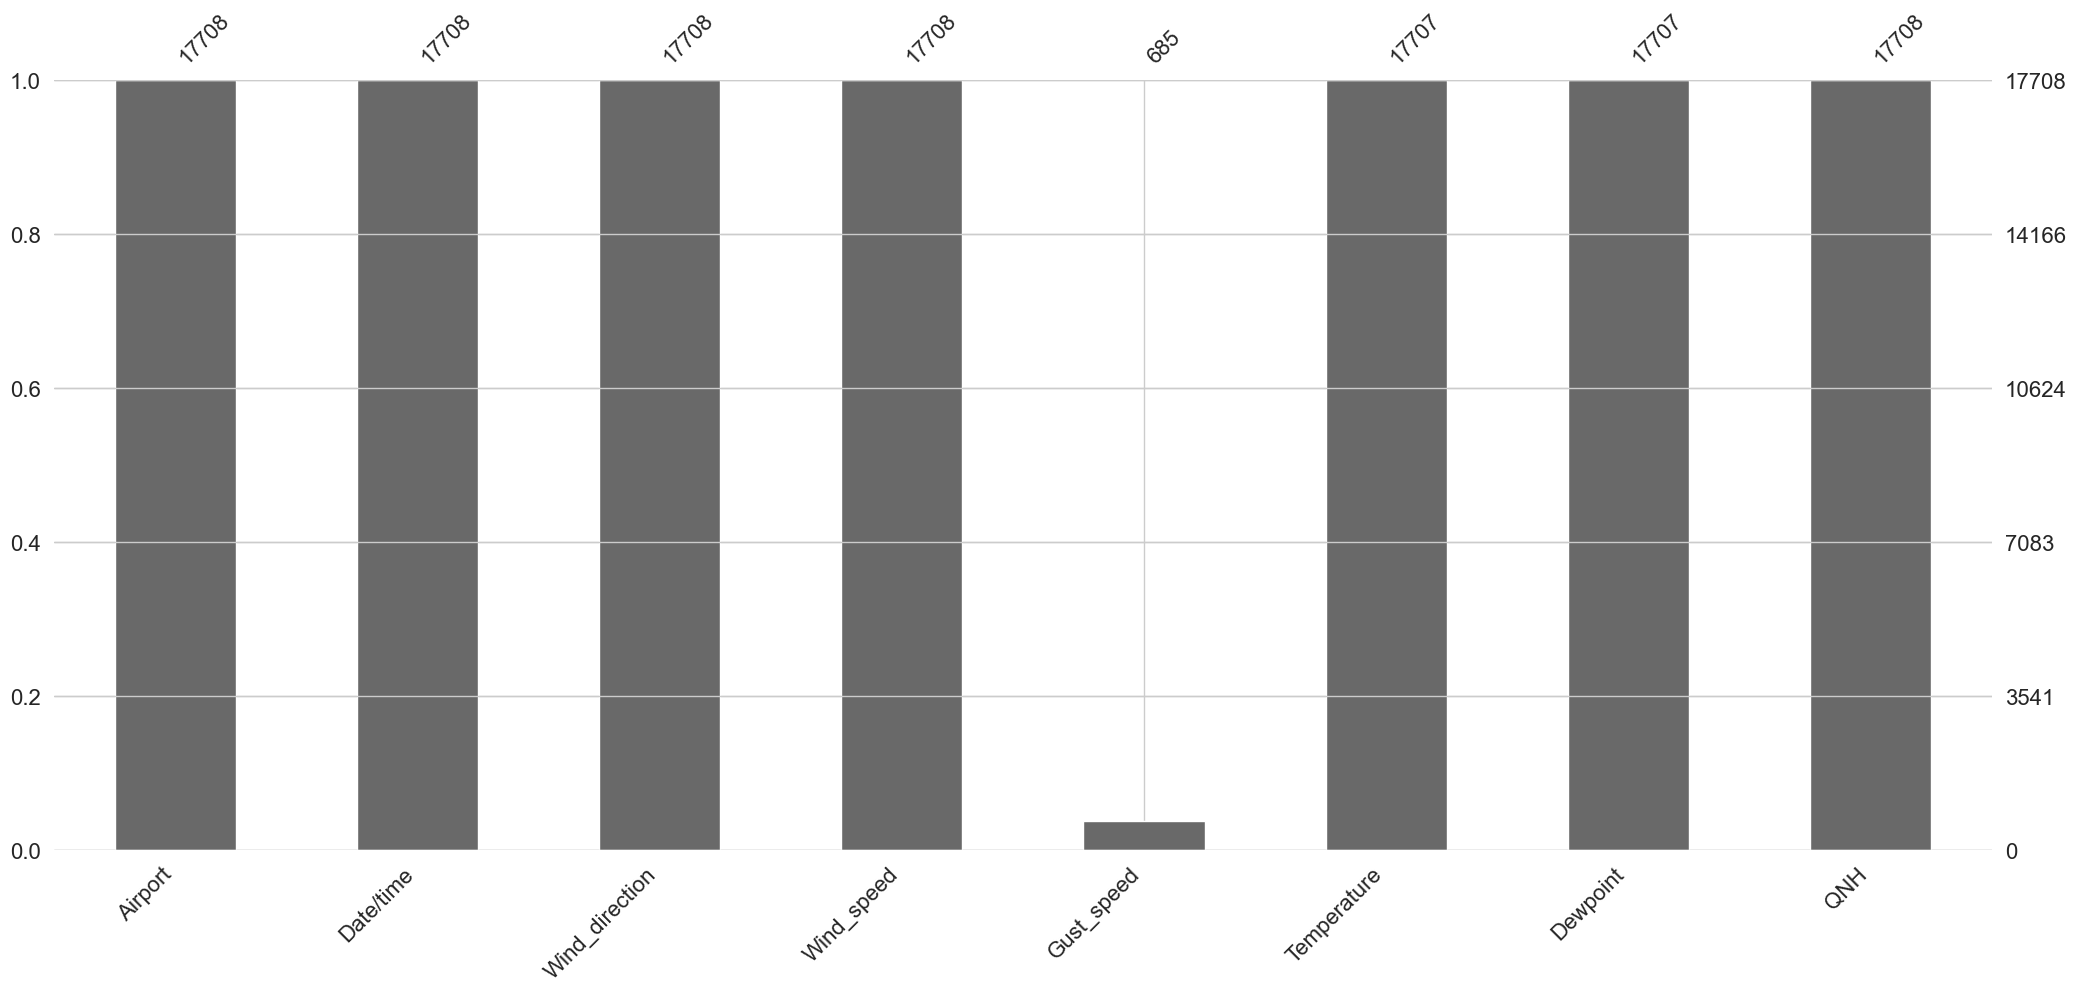

In [67]:
msno.bar(df_airport)
print("Ser etter outliers")

#### 2D Scatter-plot av vindretning og vindhastighet

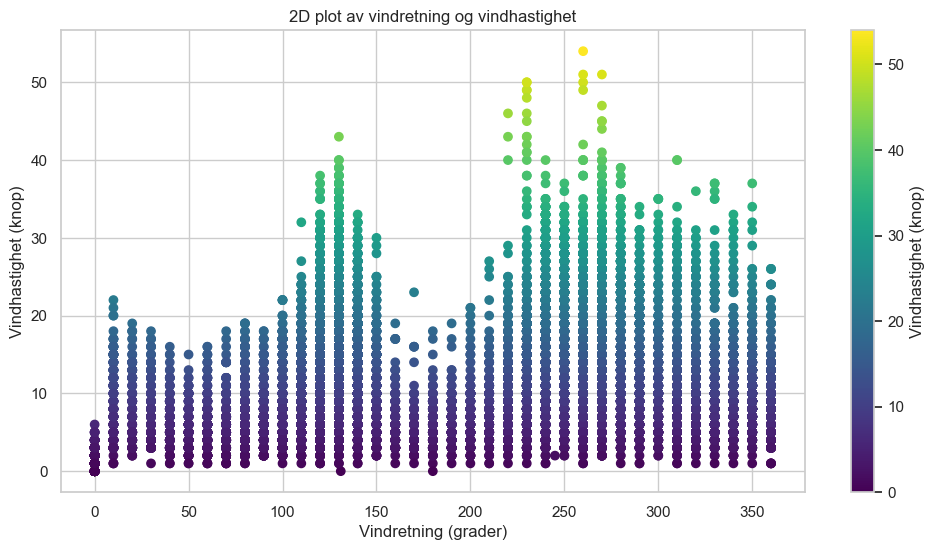

In [68]:
fig = plt.figure(figsize=(12, 6))
plt.scatter(df_airport['Wind_direction'], df_airport['Wind_speed'], c=df_airport['Wind_speed'], cmap='viridis', marker='o')
plt.title('2D plot av vindretning og vindhastighet')
plt.xlabel('Vindretning (grader)')
plt.ylabel('Vindhastighet (knop)')
plt.colorbar(label='Vindhastighet (knop)') # Legger til fargeskala
plt.grid(True)
plt.show()


#### Vindrose for aktuell flyplass

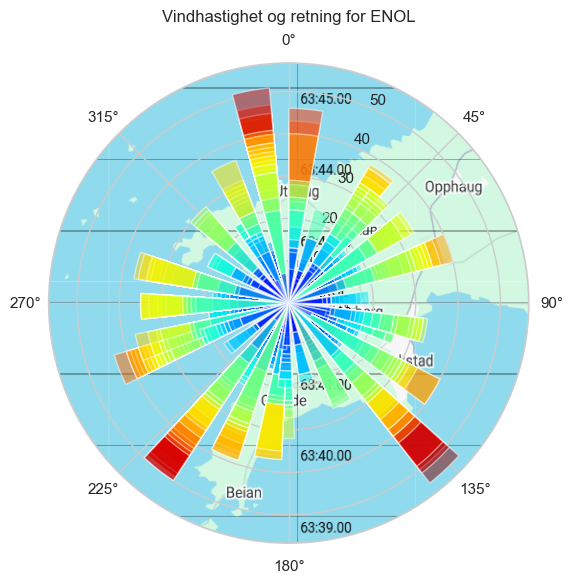

In [69]:
# Konverter vindretningen fra grader til radianer (for polarplot)
theta = df_airport['Wind_direction']
radii = df_airport['Wind_speed']

# Sett en konstant bredde for stolpene, f.eks. 10 grader (omregnet til radianer)
width = np.deg2rad(10)

# Lag figur og polar akse
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

ax.set_theta_zero_location("N") # Sett nullpunktet til nord
ax.set_theta_direction(-1)

img = plt.imread(f"../resources/images/{airport}_kart.png")
ax.imshow(img, extent=[0, 1, 0, 1], transform=ax.transAxes, zorder=0)

# Lag stolpediagrammet
bars = ax.bar(theta, radii, width=width, bottom=0.0)

# Tilpass farger etter vindhastigheten
for r, bar in zip(radii, bars):
    bar.set_facecolor(cm.jet(r / np.max(radii)))
    bar.set_alpha(0.5)

ax.set_title(f"Vindhastighet og retning for {airport}", pad=30)

plt.show()

Vindrosen gir er en god representasjon av hvor den sterke vinden kommer fra, noe som er en av de viktigste parameterene for problemstillingen vår.Den viser både retning og styrke, der den framstiller alle max verdier fra hver retning, altså 36 retninger. Det er også hentet ett bilde av kart til hver respektiv flyplass for å gi en enda tydeligere framstilling. 
#### Beregner gjennomsnittlig vindhastighet og retning på aktuell flyplass

In [70]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Antall dager per måned i 2024 (skuddår)
days_per_month = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# Beregn gjennomsnitt for hver måned
avg_wind_speed = []
avg_wind_direction = []

start_idx = 0
for days in days_per_month:
    end_idx = start_idx + 48 * days  # 48 målinger per dag (hver halvtime)
    avg_wind_speed.append(df_airport['Wind_speed'][start_idx:end_idx].mean())
    avg_wind_direction.append(df_airport['Wind_direction'][start_idx:end_idx].mean())
    start_idx = end_idx  # oppdater start for neste måned


#### Visualisering av gjennomsnittlig vind-retning og hastighet per måned

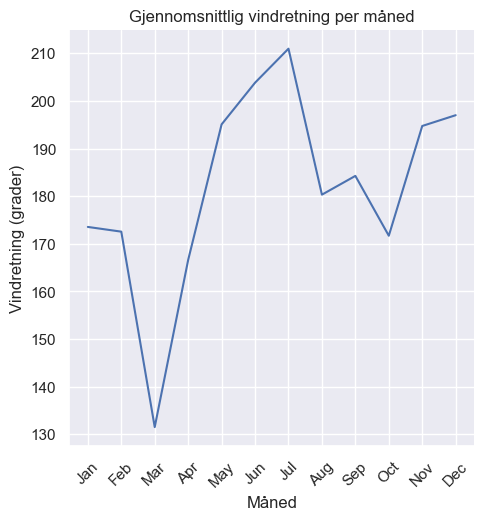

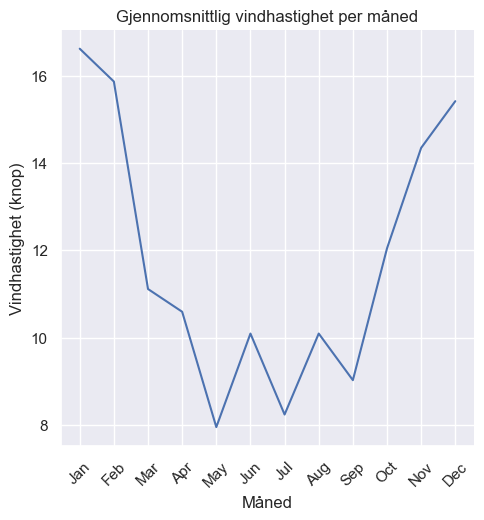

In [71]:
sns.set_theme(style="darkgrid")
sns.relplot(x = months, y = avg_wind_direction, kind="line")
plt.xticks(rotation=45)
plt.xlabel("Måned")
plt.ylabel("Vindretning (grader)")
plt.title("Gjennomsnittlig vindretning per måned")
plt.show()

# Plotting gjennomsnittlig vindhastighet per måned
sns.relplot(x = months, y = avg_wind_speed, kind="line")
plt.xticks(rotation=45)
plt.xlabel("Måned")
plt.ylabel("Vindhastighet (knop)")
plt.title("Gjennomsnittlig vindhastighet per måned")
plt.show()


Dersom vi ser på Ørland ser vi tydelig avvikk for gjennomsnittlig vindretning i mars, dette underbygger argumentet med at vind-data er ekstremt variert og vanskelig å analysere. Vi skal senere se på korrelasjon mellom disse værdataene.

Vi ser også at gjennomsnittsvinden er drastisk høyere i vintersesongen.

#### Beregner standardavvik og drøfter resultater

In [72]:
# Er standardaviken for vindhastighet og vindkast-hastighet lik?
std_wind_speed = df_airport['Wind_speed'].std()
std_gust_speed = df_airport['Gust_speed'].std()
std_wind_direction = df_airport['Wind_direction'].std()


print(f"Standardavvik vindhastighet: {std_wind_speed.round(2)} for {airport}")
print(f"Standardavvik vindkast-hastighet: {std_gust_speed.round(2)} for {airport}")
print(f"\nStandardavvik vindretning: {std_wind_direction.round(2)} for {airport}")
print(f"\nVi ser at standardavviktet ikke er alt for høyt når deg gjelder vindhastighet og vindkast-hastighet. \nMen når vi ser på vindretning er det veldig stor variasjon {std_wind_direction.round(2)}. Dette gir mening med tanke på valg av data.")

Standardavvik vindhastighet: 7.12 for ENOL
Standardavvik vindkast-hastighet: 7.38 for ENOL

Standardavvik vindretning: 93.31 for ENOL

Vi ser at standardavviktet ikke er alt for høyt når deg gjelder vindhastighet og vindkast-hastighet. 
Men når vi ser på vindretning er det veldig stor variasjon 93.31. Dette gir mening med tanke på valg av data.


Et spennede spørsmål anngående standardavviket er hvordan den oppfører seg avhengig av trykket. Det ser vi nærmere på nedenfor, men først introduserer vi de variablene opp mot hverandre i form av korrelasjonsgrafer.

#### Vindhastighet sammenlignet med trykk (QNH)

Korrelasjon mellom vindhastighet og trykk (QNH) er -0.26


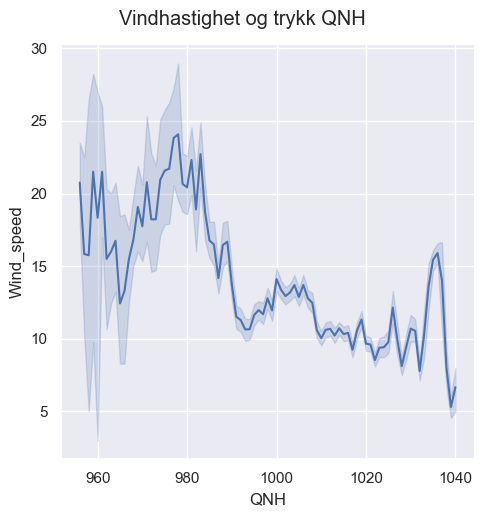

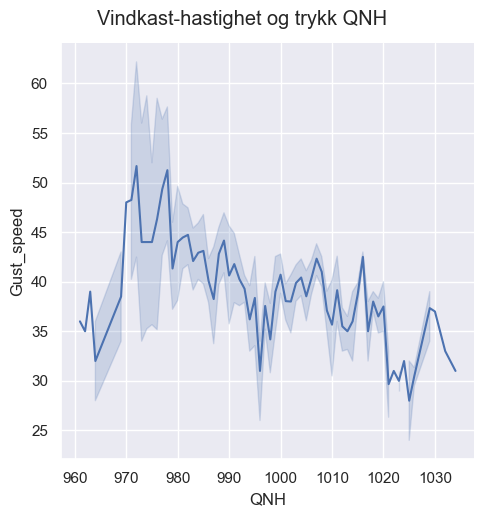

In [73]:
correlation = df_airport['Wind_speed'].corr(df_airport['QNH'])
print(f"Korrelasjon mellom vindhastighet og trykk (QNH) er {correlation.round(2)}")

# plott 1
plot1 = sns.relplot(x="QNH", y="Wind_speed", kind="line", data=df_airport)
_ = plot1.fig.suptitle("Vindhastighet og trykk QNH", y=1.03)

# plott 2
plot2 = sns.relplot(x="QNH", y="Gust_speed", kind="line", data=df_airport)
_ = plot2.fig.suptitle("Vindkast-hastighet og trykk QNH", y=1.03)

Vi ser en sammenheng mellom vindhastighet og trykk QNH.
Når trykket er lavt er det høyere vindhastighet enn når trykket er høyt.
Dette gir mening med tanke på at lavtrykk gir mer vind og høytrykk gir mindre vind.
Samme gjelder for Vindkast-hastighet, vinden er mer uregelmessig når trykket er lavt.

Vi får også dette bekreftet ved å se på korrelasjonen, nedenfor ser vi nærmere på det i Kryss-korrelasjonsdiagrammet.

In [74]:
df_QNH_lavtrykk = df_airport[df_airport['QNH'] < 980] # Lavtrkk hentet fra SNL
df_QNH_normaltrykk = df_airport[(df_airport['QNH'] >= 980) & (df_airport['QNH'] < 1025)] # Normaltrykk hentet fra SNL
df_QNH_høytrykk = df_airport[df_airport['QNH'] >= 1025] # Høytrykk hentet fra SNL

lavtrykk_wind_speed = df_QNH_lavtrykk['Wind_speed'].std().round(2)
normaltrykk_wind_speed = df_QNH_normaltrykk['Wind_speed'].std().round(2)
høytrykk_wind_speed = df_QNH_høytrykk['Wind_speed'].std().round(2)

print(f"Standardavvik vindhastighet ved lavtrykk: {lavtrykk_wind_speed}")
print(f"Standardavvik vindhastighet ved normaltrykk: {normaltrykk_wind_speed}")
print(f"Standardavvik vindhastighet ved høytrykk: {høytrykk_wind_speed}")

Standardavvik vindhastighet ved lavtrykk: 9.97
Standardavvik vindhastighet ved normaltrykk: 7.02
Standardavvik vindhastighet ved høytrykk: 5.79


Vi ser her at det er større varriasjon når det er lavtrykk, enn normal og høytrykk. Dette bekrefter mistanken vår om at det er mindre variasjon i vindhastighet desto høyere trykk det er.

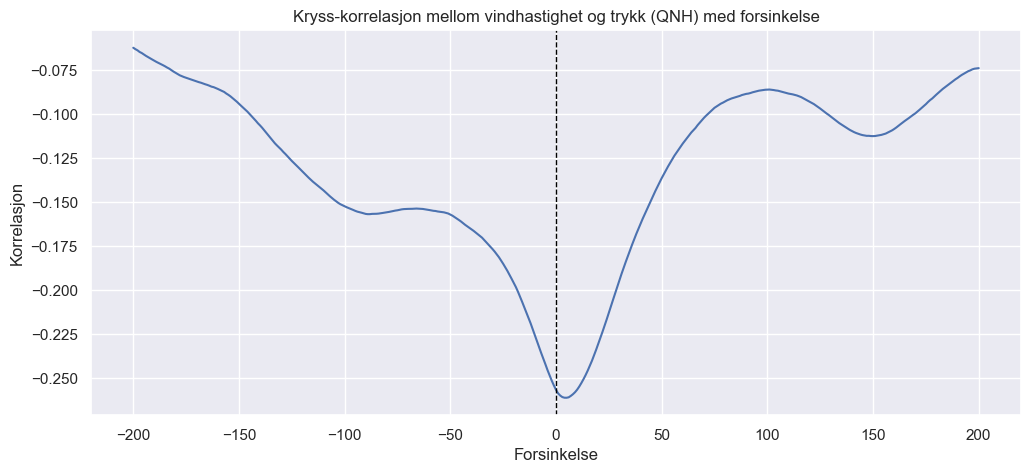

In [75]:
max_lag = 200
lags = np.arange(-max_lag, max_lag + 1)
cross_corr = [df_airport['Wind_speed'].corr(df_airport['QNH'].shift(lag)) for lag in lags]

plt.plot(lags, cross_corr)
plt.title('Kryss-korrelasjon mellom vindhastighet og trykk (QNH) med forsinkelse')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Forsinkelse')
plt.ylabel('Korrelasjon')
plt.grid(True)
plt.show()


Vi ser her at når QNH er lav er det en 25% korrelasjon for at vindhastigheten er høy, og motsatt.
Her har vi også lagt inn forsinkelse, og vi ser at jo mer forsinkelse på en av verdiene desto mindre korrelasjon er det. hvert 48-ende punt representerer ett døgn. Dette korrelasjonsdiagrammet bruker vi videre nedenfor med andre variabler.

#### Kryss-korrelasjon mellom vindkast-hastighet og trykk (QNH) med forsinkelse

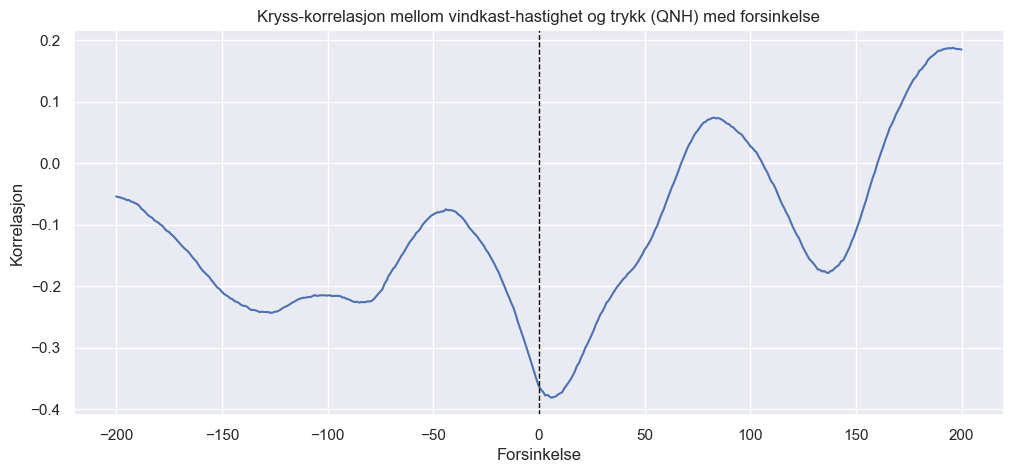

In [76]:
max_lag = 200
lags = np.arange(-max_lag, max_lag + 1)
cross_corr = [df_airport['Gust_speed'].corr(df_airport['QNH'].shift(lag)) for lag in lags]

plt.plot(lags, cross_corr)
plt.title('Kryss-korrelasjon mellom vindkast-hastighet og trykk (QNH) med forsinkelse')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Forsinkelse')
plt.ylabel('Korrelasjon')
plt.grid(True)
plt.show()

#### Kryss-korrelasjon mellom vindhastighet og vindkast-hastighet med forsinkelse

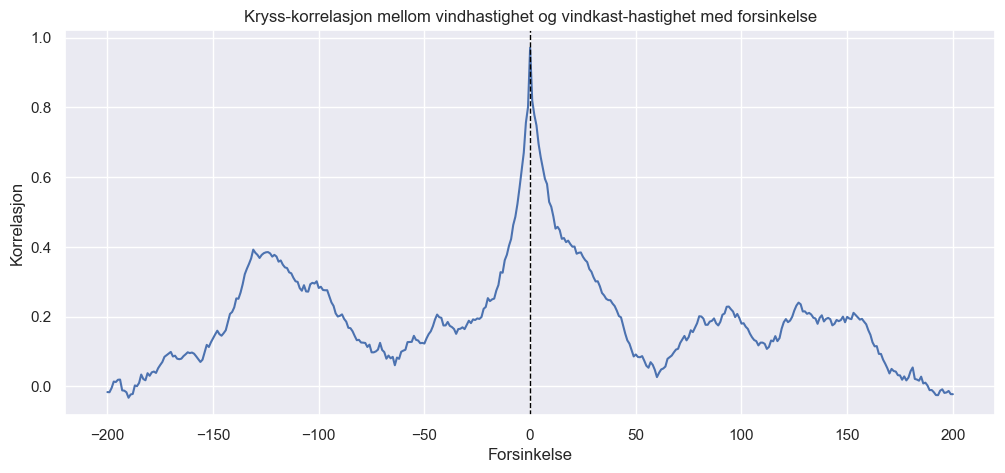

In [77]:
max_lag = 200
lags = np.arange(-max_lag, max_lag + 1)
cross_corr = [df_airport['Wind_speed'].corr(df_airport['Gust_speed'].shift(lag)) for lag in lags]

plt.plot(lags, cross_corr)
plt.title('Kryss-korrelasjon mellom vindhastighet og vindkast-hastighet med forsinkelse')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Forsinkelse')
plt.ylabel('Korrelasjon')
plt.grid(True)
plt.show()

Her ser vi en enorm korrelasjon, når vindhastighet er høy er vindkast-hastighet alltid høy, altså 100% korrelasjon med ingen forsinkelse. Med forsinkelse ser vi at korrelasjonen dropper, desto flere steg vi tar.

#### Kryss korrelasjon av vindretning og andre variabler

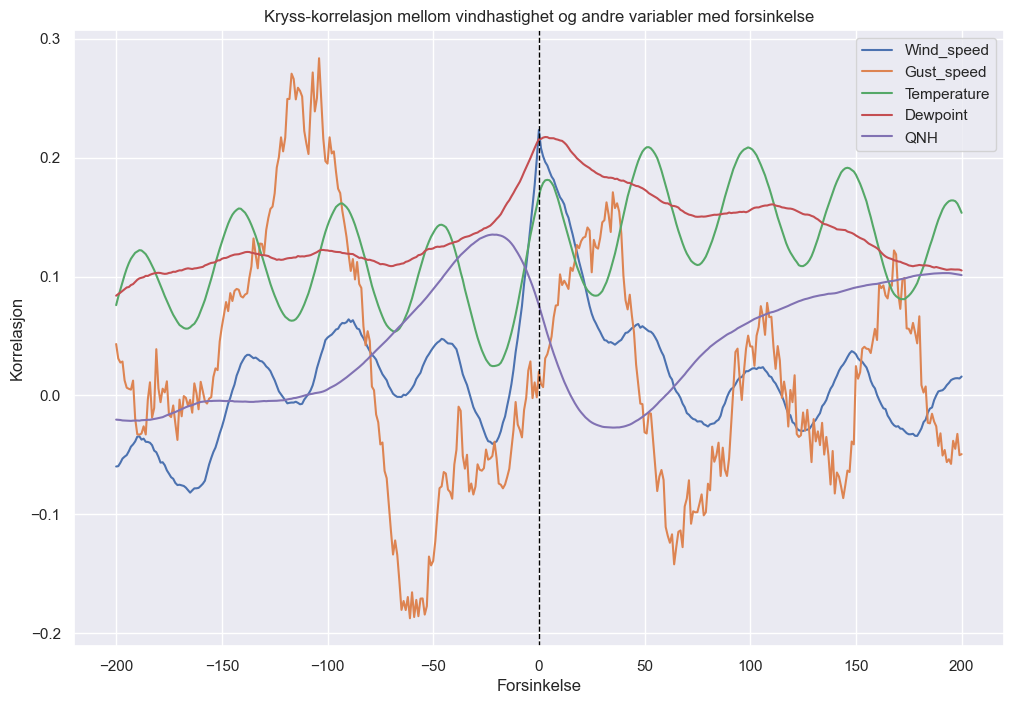

In [81]:
max_lag = 200
lags = np.arange(-max_lag, max_lag + 1)

plt.figure(figsize=(12, 8))

for col in ['Wind_speed', 'Gust_speed', 'Temperature', 'Dewpoint', 'QNH']:
    cross_corr = [df_airport['Wind_direction'].corr(df_airport[col].shift(lag)) for lag in lags]
    plt.plot(lags, cross_corr, label=col)

plt.title('Kryss-korrelasjon mellom vindhastighet og andre variabler med forsinkelse')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Forsinkelse')
plt.ylabel('Korrelasjon')
plt.legend()
plt.grid(True)
plt.show()

#### Kryss korrelasjon av Vind hastighet og andre variabler

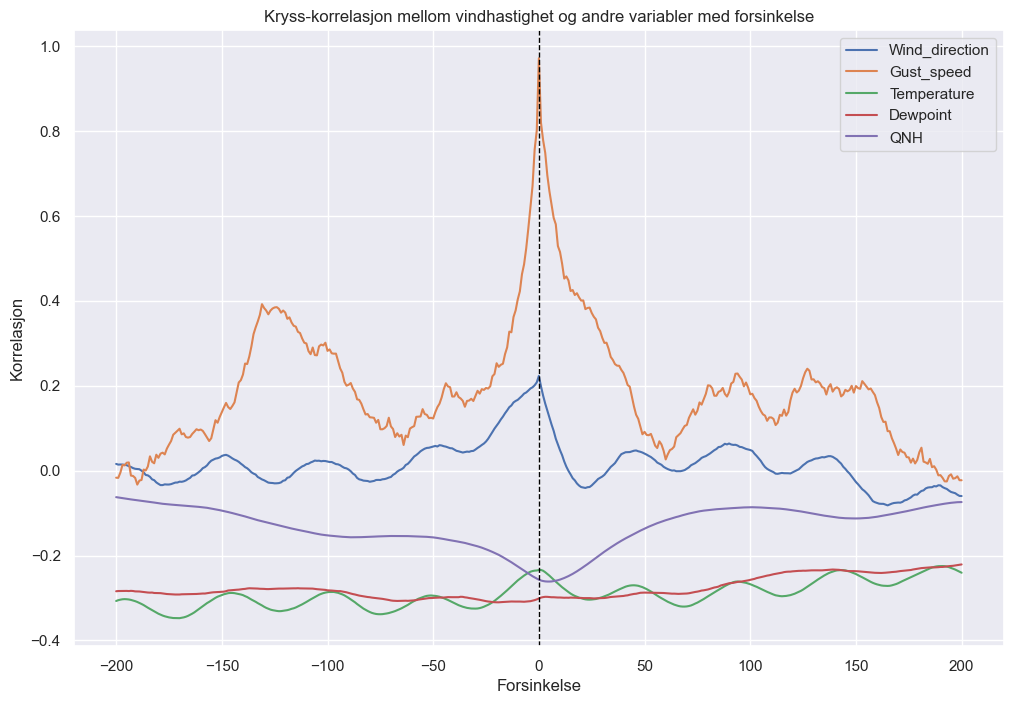

In [78]:
max_lag = 200
lags = np.arange(-max_lag, max_lag + 1)

plt.figure(figsize=(12, 8))

for col in ['Wind_direction', 'Gust_speed', 'Temperature', 'Dewpoint', 'QNH']:
    cross_corr = [df_airport['Wind_speed'].corr(df_airport[col].shift(lag)) for lag in lags]
    plt.plot(lags, cross_corr, label=col)

plt.title('Kryss-korrelasjon mellom vindhastighet og andre variabler med forsinkelse')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Forsinkelse')
plt.ylabel('Korrelasjon')
plt.legend()
plt.grid(True)
plt.show()

Beregner korrelasjon uten forsinkelse

In [83]:
correlation_1 = df_airport['Wind_speed'].corr(df_airport['Gust_speed'])
correlation_2 = df_airport['Wind_speed'].corr(df_airport['Wind_direction'])
correlation_3 = df_airport['Wind_speed'].corr(df_airport['QNH'])
correlation_4 = df_airport['Wind_speed'].corr(df_airport['Temperature'])
correlation_5 = df_airport['Wind_speed'].corr(df_airport['Dewpoint'])

Resultat av korrelasjon uten forsinkelse

In [85]:
print(f"Korrelasjon mellom vindhastighet og vindkast-hastighet er {correlation_1.round(2)}")
print(f"Korrelasjon mellom vindhastighet og vindretning er {correlation_2.round(2)}")
print(f"Korrelasjon mellom vindhastighet og trykk (QNH) er {correlation_3.round(2)}")
print(f"Korrelasjon mellom vindhastighet og temperatur er {correlation_4.round(2)}")
print(f"Korrelasjon mellom vindhastighet og duggpunkt er {correlation_5.round(2)}")

Korrelasjon mellom vindhastighet og vindkast-hastighet er 0.97
Korrelasjon mellom vindhastighet og vindretning er 0.22
Korrelasjon mellom vindhastighet og trykk (QNH) er -0.26
Korrelasjon mellom vindhastighet og temperatur er -0.23
Korrelasjon mellom vindhastighet og duggpunkt er -0.3


Vi ser at det er stor korrelasjon mellom vindhastighet og vindkast-hastighet, hele 97%. 
Ig mindre korrelasjon mellom de andre variablene.

Når korrelasjonsverdien er negativ sier den at den ene verdien er lav når den andre er høy. For eksempel når vindhastigheten er høy er trykket lavt.

#### Dynamisk Histogram (KDE analyse) med glattingskostnat

In [80]:
#henter fil fra src mappa.
sys.path.insert(0, '../src/')
from avg_widget import avg_widget

# Interaktiv widget
widgets.interact(
    avg_widget, 
    ses=widgets.FloatSlider(min=0.1, max=5, step=0.25, value=2.5, description='Glatting (ses)')
)

interactive(children=(FloatSlider(value=2.5, description='Glatting (ses)', max=5.0, min=0.1, step=0.25), Outpu…

<function avg_widget.avg_widget(ses=2.5)>

Arealt under kurven til et histogram er alltid 1, da dette representerer hele fordelingen av data.

Simple exponential smoothing er forkortet som ses.
